In [1]:
from linkedin_api import Linkedin
import numpy as np
from bs4 import BeautifulSoup
import requests
import pandas as pd
import glob
import json
import uuid
import random
from faker import Faker
import networkx as nx
import itertools
import time
from networkx.algorithms import bipartite
import unicodedata
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib
import warnings
from wonderwords import RandomWord
warnings.filterwarnings("ignore")
import scipy.stats as st

In [2]:
def add_edge(graph,df,period,columns,period_column):
    
    df = df[df[str(period_column)] == period][columns]
    df.drop(str(period_column), axis = 1, inplace = True)
    
    for edge in df.to_records(index=False):
        graph.add_edge(*edge)
        
    return graph

def define_graph_period(period, nodes, df,columns, period_colum = 'year'):
    _period = nx.Graph()
    for node in nodes:
        _period.add_node(node)
    _period = add_edge(_period, df, period,columns, period_colum)
    return _period

def proyection_bipartite(graph, year, list_,partition):
    _temp = bipartite.projected_graph(graph,partition)
    add  = (_temp,year)
    list_.append(add)
    return list_     

In [3]:
def random_walk_list(data_random_walk):
    #Instanciamos RandomsWords
    
    rw = RandomWord()
    
    #Leemos resultados de la simulacion
    random_walk =  pd.read_csv(data_random_walk)
    #random_walk = data_random_walk
    
    #Numero de nodos
    N_people = len(np.unique(random_walk.Rw))
    N_companys = len(np.unique(random_walk.N_visited))
    N_nodos = len(np.append(np.unique(random_walk.Rw),np.unique(random_walk.N_visited) ))
    
    #Creamos listas con palabras
    Words = pd.DataFrame(rw.random_words(N_nodos))
    
    #Mapamos 
    D_people = Words[0].iloc[:N_people]
    D_company = Words[0].iloc[N_people:].reset_index(drop = True)
    
    D_people = {key:value for key,value in D_people.items()}
    D_company = {random_walk.N_visited.sort_values().unique()[i]:D_company.sort_values().unique()[i] for i in range(N_companys)}
    
    random_walk.Rw = random_walk.Rw.map(D_people)
    random_walk.N_visited = random_walk.N_visited.map(D_company)
    
    #Definimos Graph
    graph = random_walk
    
    companys = graph.N_visited.unique()
    people = graph.Rw.unique()
    
    #Creamos los nodos
    nodes = np.append(np.unique(random_walk.Rw.astype(str)),np.unique(random_walk.N_visited.astype(str)) )
    
    #Creamos los grafos
    columns = ['t','Rw','N_visited']
    years = []
    graphs_list_Rw = []
    for period in np.sort(graph.t.unique()):
        _temp = define_graph_period(period,nodes,graph,columns, period_colum = 't')
        _period = str(period)
        years.append(period)
        add = (_temp,_period)
        graphs_list_Rw.append(add)
        
    return graphs_list_Rw, companys, people, years,graph

def bipartite_list(list_, projector):
    graphs_list_month_Rw = []
    for graph, year in list_:
        proyection_bipartite(graph, year, graphs_list_month_Rw,projector)
    return graphs_list_month_Rw

def k_average(graph_list):
    return [pd.DataFrame(nx.degree(value)).mean().values for value,key in graph_list]

def C_average(graph_list):
    return [np.array(list(nx.clustering(value).values())).mean() for value,key in graph_list]

def second_criteria(graphs_list_Rw):
    #Segundo Criterio
    for i in range(len(graphs_list_Rw)-1):
        for edge in graphs_list_Rw[i][0].edges():
            graphs_list_Rw[i+1][0].add_edge(*edge)
    return graphs_list_Rw

# Creamos las redes por mes

In [125]:
#Leemos los archivos
uuids = pd.read_csv('uuids merama.csv')
DF_to_adjacency_matrix_month = pd.read_excel('DF_to_adjacency_matrix_month.xlsx',index = False).sort_values(['uuid','period']).drop_duplicates()
#Seleccionamos los que esten en merama
DF_to_adjacency_matrix_month = DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.uuid.isin(uuids.uuid)].drop('industry', axis = 1)

In [127]:
# Tomamos todos los que tienen fecha arriba de 2010-01
DF_to_adjacency_matrix_month = DF_to_adjacency_matrix_month[(DF_to_adjacency_matrix_month.period >= '2010-01')]

In [6]:
#Primer intento agrupar y quedarnos solo con el primer trabajo: NOTA ESTO GENERA PROBELMAS YA QUE ALGUNOS NO LES CONSIDERA EMRAMA COMO SU PRIMER EMPRESA
DF_to_adjacency_matrix_month = DF_to_adjacency_matrix_month.groupby(['uuid','period']).first().reset_index()

In [7]:
#Cambios
P_period = DF_to_adjacency_matrix_month[(DF_to_adjacency_matrix_month.period <= '2020-10') & (DF_to_adjacency_matrix_month.period >= '2010-01')]

In [8]:
changes = []
P_period_df = pd.DataFrame()
for uuid in P_period.uuid.unique():
    _aux = P_period[P_period.uuid == uuid].sort_values('period').reset_index(drop = True)
    changes.append(0)
    for row in range(len(_aux)-1):
        #print(_aux.iloc[row + 1])
        if _aux.iloc[row + 1].company != _aux.iloc[row].company:
            changes.append(1)
            #print('*'*20)
        else:
            changes.append(0)
    P_period_df = pd.concat([P_period_df,_aux])

In [9]:
P_period_df['changes'] = changes

In [10]:
P_de_cambio = pd.pivot_table(P_period_df, index = 'period', columns = 'changes', values = 'uuid', aggfunc = 'nunique').fillna(0)
P_de_cambio['total'] = P_de_cambio[0] + P_de_cambio[1]
dist_de_cambio = P_de_cambio[1]/P_de_cambio['total']

In [11]:
#Creamos los bins
#Usando la regla de Freedamn.Diaconis
q25, q75 = np.percentile(dist_de_cambio, [25, 75])
bin_width = 2 * (q75 - q25) * (len(dist_de_cambio) ** (-1/3))
bins = round((dist_de_cambio.max() - dist_de_cambio.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

Freedman–Diaconis number of bins: 5


In [12]:
#Probabilidad media de cambiarse 
dist_de_cambio.mean()*100

1.8618765212497501

In [13]:
#Seleccinamos todo lo mayor a 2010
graph = DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.period >= '2010-01']

In [14]:
#Valores
print("Total personas", graph.uuid.nunique())
print("Total compañias", graph.company.nunique())
print("Total periodos", graph.period.nunique())

Total personas 386
Total compañias 775
Total periodos 155


In [15]:
#Creamos los nodos
nodes = np.append(np.unique(graph.uuid),np.unique(graph.company) )

In [16]:
columns = ['period','uuid','company']
years = []
graphs_list = []
for period in np.sort(graph.period.unique()):
    _temp = define_graph_period(period,nodes,graph,columns, period_colum = 'period')
    _period = str(period)
    years.append(period)
    add = (_temp,_period)
    graphs_list.append(add)

In [17]:
companys = graph.company.unique()
people = graph.uuid.unique()

In [18]:
#Companys
graphs_list_c_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_c_month,companys)

In [19]:
#People
graphs_list_p_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_p_month, people)

In [20]:
#Evolucion de la <k> y <C>
k_average_c_1_month  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_c_month]
k_average_p_1_month  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_p_month]
C_average_c_1_month  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_c_month]
C_average_p_1_month  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_p_month]

In [21]:
#Segundo Criterio
for i in range(len(graphs_list)-1):
    for edge in graphs_list[i][0].edges():
        graphs_list[i+1][0].add_edge(*edge)

In [22]:
#Companys
graphs_list_c_2_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_c_2_month,companys)

In [23]:
#People
graphs_list_p_2_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_p_2_month, people)

In [24]:
#Evolucion de la <k> y <C>
k_average_c_2_month  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_c_2_month]
k_average_p_2_month  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_p_2_month]
C_average_c_2_month  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_c_2_month]
C_average_p_2_month  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_p_2_month]

# Graficas mensuales

In [26]:
#Distribucion de empresas un mes antes de la formacion de merama
dist_companys_2020_09 = (DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.period == '2020-09']
                         .groupby('company')
                         .nunique()['uuid']
                         .sort_values())
val = dist_companys_2020_09[-10:].index
freq = dist_companys_2020_09[-10:].values

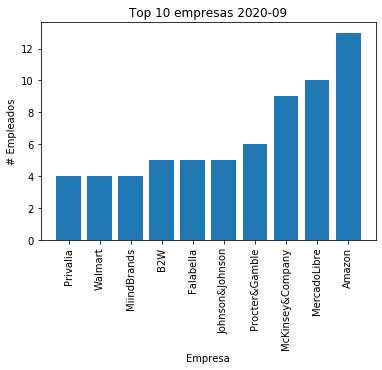

In [27]:
plt.bar(val,freq)
plt.xticks(rotation = 90, fontsize = 10)
plt.ylabel("# Empleados")
plt.xlabel('Empresa')
plt.title('Top 10 empresas 2020-09')
plt.savefig('./images/Top_10_empresas_2020_09.jpeg',bbox_inches = 'tight')
plt.show()

In [28]:
#Distribucion de empresas un mes antes de la formacion de merama
dist_companys_2020_09 = (DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.period == '2020-11']
                         .groupby('company')
                         .nunique()['uuid']
                         .sort_values())
val = dist_companys_2020_09[-10:].index
freq = dist_companys_2020_09[-10:].values

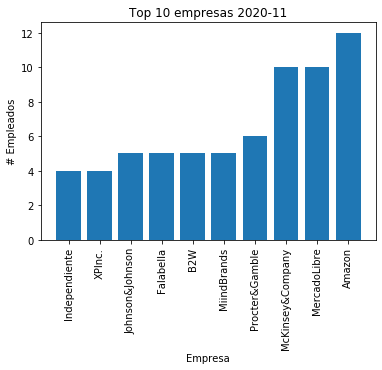

In [29]:
plt.bar(val,freq)
plt.xticks(rotation = 90, fontsize = 10)
plt.ylabel("# Empleados")
plt.xlabel('Empresa')
plt.title('Top 10 empresas 2020-11')
plt.savefig('./images/Top_10_empresas_2020_11.jpeg',bbox_inches = 'tight')
plt.show()

In [30]:
perids = [i for i in range(len(years))]

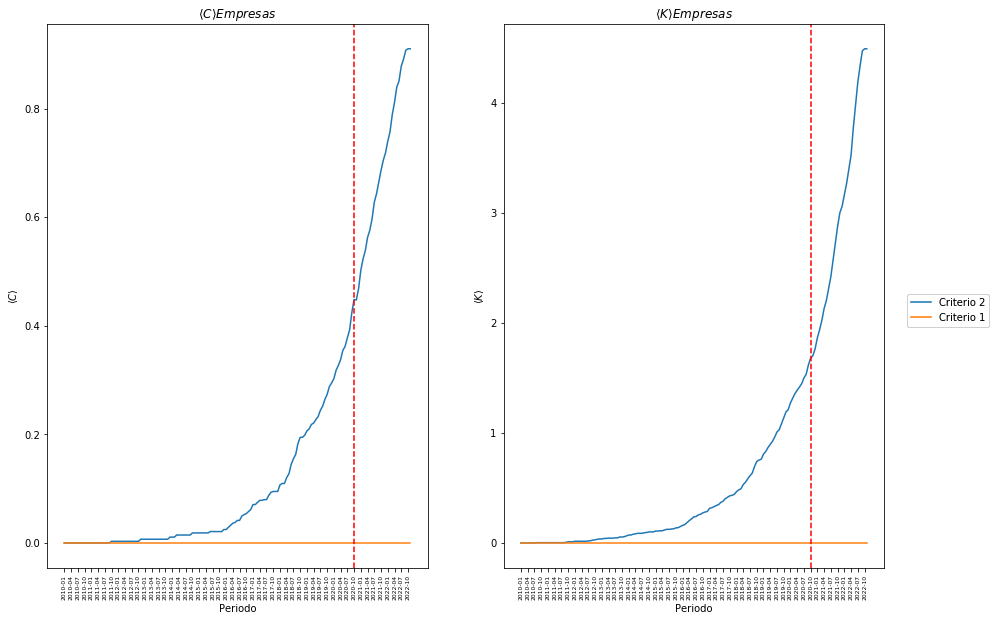

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,10))
line_labels = ['Criterio 1','Criterio 2']

axes[0].plot(years, C_average_c_2_month, label = 'Criterio 2')
axes[0].plot(years, C_average_c_1_month, label = 'Criterio 1')
axes[0].axvline(129,c = 'r', linestyle =  '--')

axes[0].set_title(r'$\langle C \rangle  Empresas$')
axes[0].set_ylabel(r'$\langle C \rangle$')
axes[0].set_xlabel('Periodo')
axes[0].set_xticks(years[::3])
axes[0].set_xticklabels(years[::3],rotation = 90, fontsize = 6)

axes[1].plot(years, k_average_c_2_month)
axes[1].plot(years, k_average_c_1_month)
axes[1].axvline(129,c = 'r',linestyle =  '--')

axes[1].set_title(r'$\langle K \rangle  Empresas$')
axes[1].set_ylabel(r'$\langle K \rangle$')
axes[1].set_xlabel('Periodo')
axes[1].set_xticks(years[::3])
axes[1].set_xticklabels(years[::3],rotation = 90, fontsize = 6)


lines = []
labels = []

for ax in  fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

    fig.legend(lines, labels,           
           loc="right") 
plt.savefig('./images/Red_original_centralidad_empresas.jpeg')
plt.show()

In [32]:
element_k_c_2_a = graphs_list_c_2_month[128][0]
Gcc_k_c_2_a = sorted(nx.connected_components(element_k_c_2_a), key=len, reverse=True)
G0_k_c_2_a = element_k_c_2_a.subgraph(Gcc_k_c_2_a[0])

In [33]:
val = pd.DataFrame(nx.degree(G0_k_c_2_a)).sort_values(1).iloc[-10:][0]
freq = pd.DataFrame(nx.degree(G0_k_c_2_a)).sort_values(1).iloc[-10:][1]

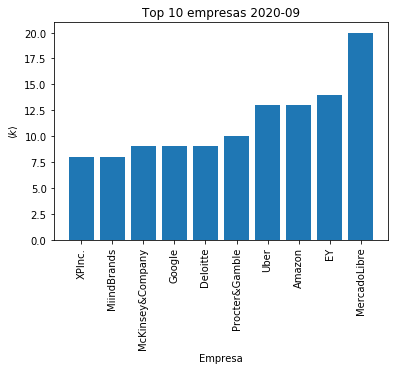

In [34]:
plt.bar(val,freq)
plt.xticks(rotation = 90, fontsize = 10)
plt.ylabel(r"$\langle k \rangle$")
plt.xlabel('Empresa')
plt.title('Top 10 empresas 2020-09')
plt.savefig('./images/Top_10_empresas_k_mean_2020_09.jpeg',bbox_inches = 'tight')
plt.show()

In [35]:
nodes = ['MercadoLibre','EY','Uber','Amazon','Procter&Gamble']
colors = ['red' if node in nodes else 'lightblue' for node in G0_k_c_2_a.nodes()]

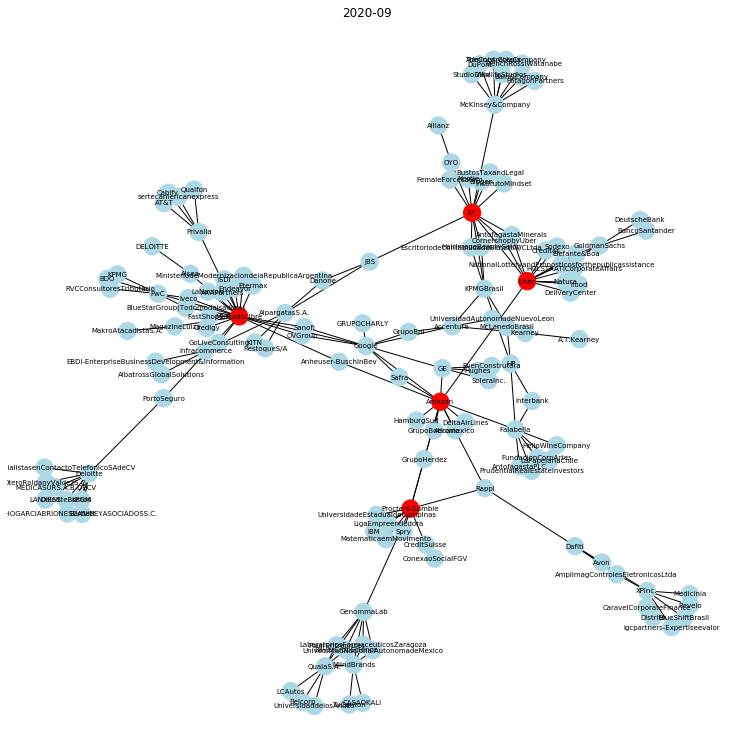

In [36]:
plt.figure(3,figsize=(10,10))
nx.draw_spring(G0_k_c_2_a, node_color=colors, with_labels = True, font_size = 7)
plt.title('2020-09')
plt.savefig('./images/G0_k_c_2_a.jpeg',bbox_inches = 'tight')

In [70]:
element_k_c_2_d = graphs_list_c_2_month[135][0]
Gcc_k_c_2_d = sorted(nx.connected_components(element_k_c_2_d), key=len, reverse=True)
G0_k_c_2_d = element_k_c_2_d.subgraph(Gcc_k_c_2_d[0])

In [89]:
graphs_list_c_2_month[135]

(<networkx.classes.graph.Graph at 0x23e6d600888>, '2021-04')

In [72]:
pd.DataFrame(nx.degree(G0_k_c_2_d)).sort_values(1).iloc[-10:]

,0,1
6,Falabella,10
184,Deloitte,11
22,Procter&Gamble,11
93,XPInc.,12
213,McKinsey&Company,12
20,Uber,14
133,Amazon,16
81,EY,19
169,MercadoLibre,25
42,Merama,68


In [73]:
val = pd.DataFrame(nx.degree(G0_k_c_2_d)).sort_values(1).iloc[-10:][0]
freq = pd.DataFrame(nx.degree(G0_k_c_2_d)).sort_values(1).iloc[-10:][1]

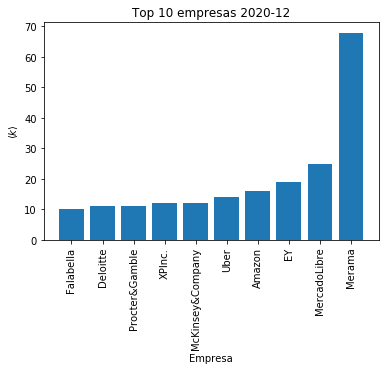

In [74]:
plt.bar(val,freq)
plt.xticks(rotation = 90, fontsize = 10)
plt.ylabel(r"$\langle k \rangle$")
plt.xlabel('Empresa')
plt.title('Top 10 empresas 2020-12')
#plt.savefig('./images/Top_10_empresas_k_mean_2020_12.jpeg',bbox_inches = 'tight')
plt.show()

In [75]:
nodes = ['MercadoLibre','EY','Uber','Amazon','Deloitte']
colors = ['red' if node in nodes else 'green' if node == 'Merama' else 'lightblue' for node in G0_k_c_2_d.nodes()]

Text(0.5, 1.0, '2020-12')

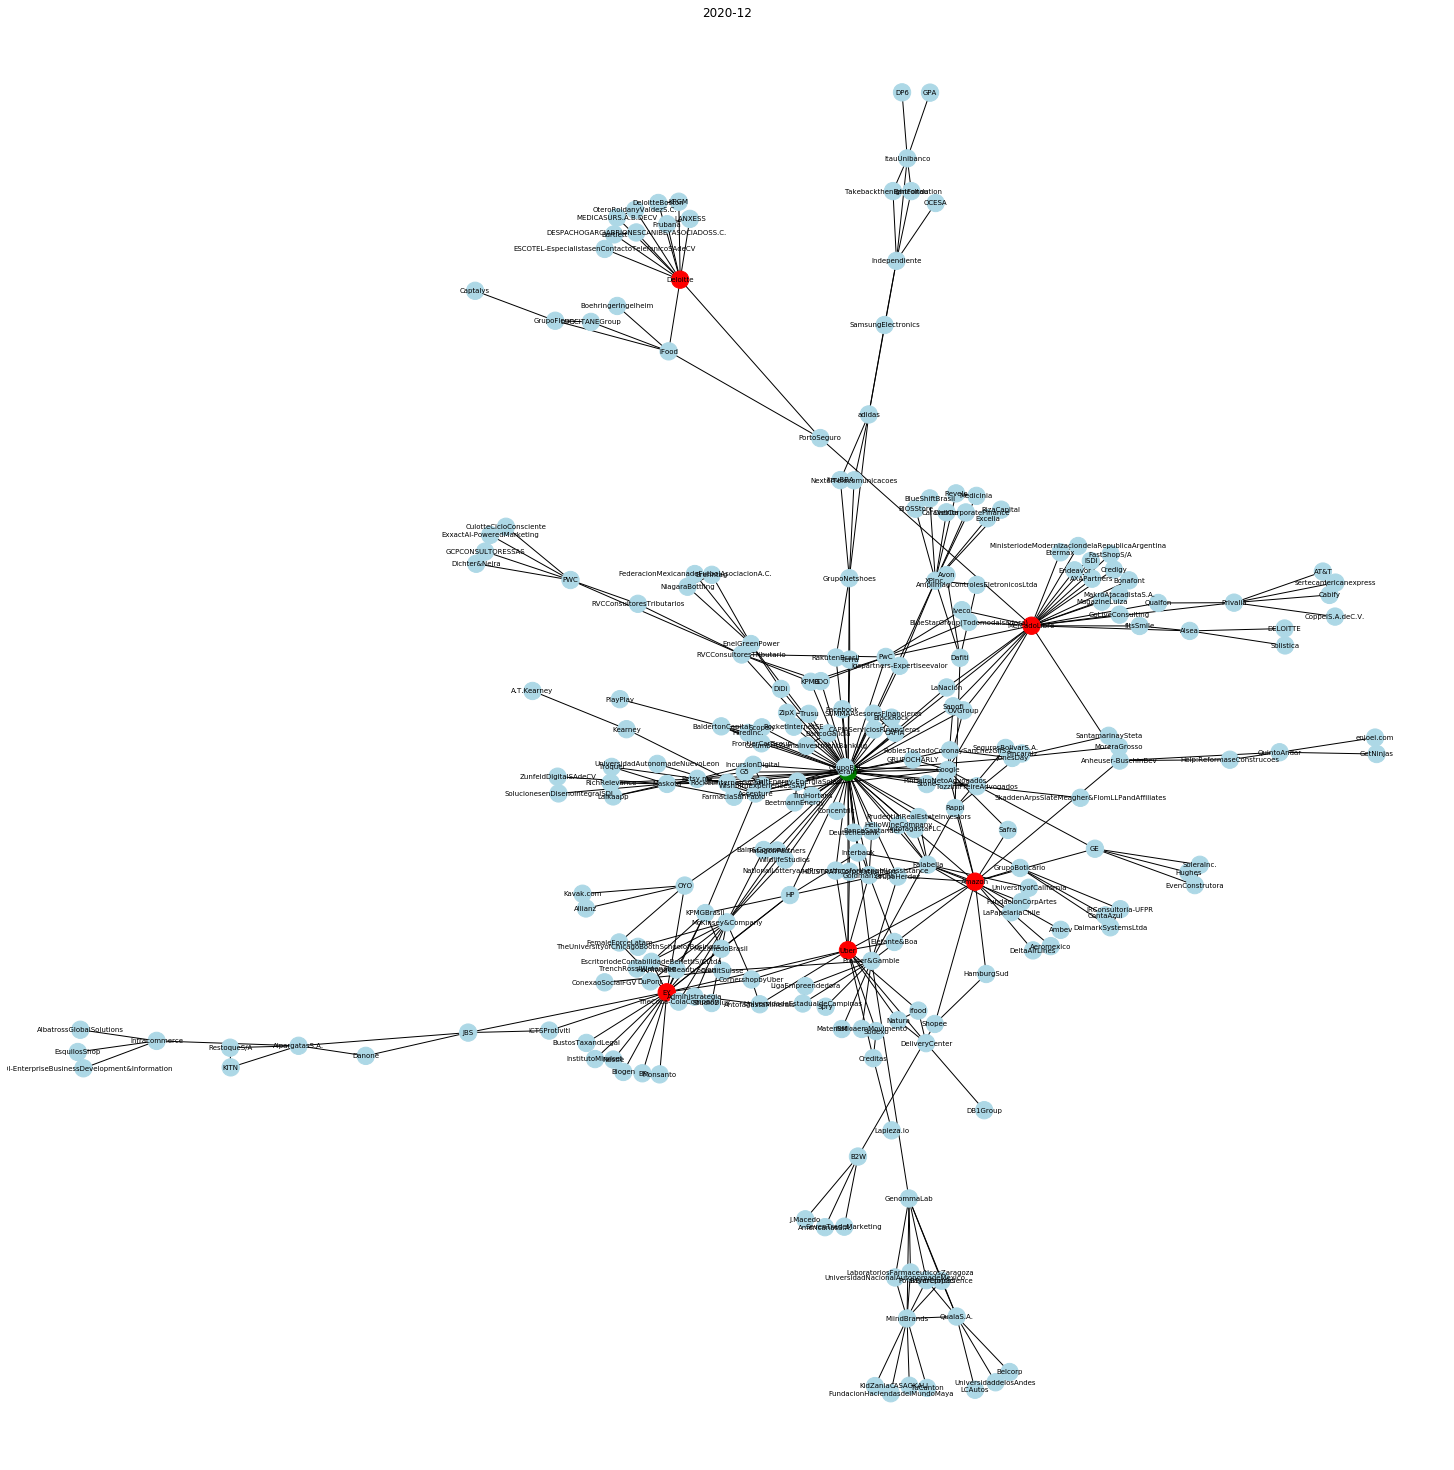

In [77]:
plt.figure(3,figsize=(20,20))
nx.draw_spring(G0_k_c_2_d, node_color=colors, with_labels = True, font_size = 7)
plt.title('2020-12')
#plt.savefig('./images/G0_k_c_2_d.jpeg',bbox_inches = 'tight')

In [80]:
DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.company == 'Deloitte'].uuid.value_counts()

d7604342    117
af3b5a91     77
e4d08ebe     57
c1fa924e     54
b17078ee     47
d2d07223     38
4fab2ad8     24
d48457df      6
Name: uuid, dtype: int64

In [101]:
DF_to_adjacency_matrix_month[(DF_to_adjacency_matrix_month.company == 'PortoSeguro')].uuid.value_counts()

57c2747f    24
d48457df    15
Name: uuid, dtype: int64

In [339]:
##PErsonas

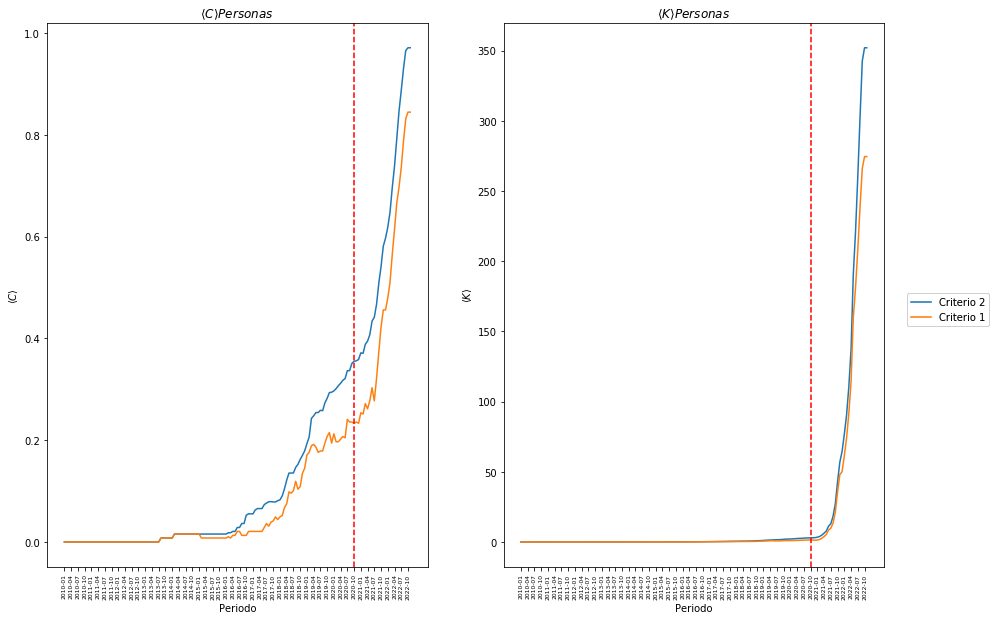

In [341]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,10))
line_labels = ['Criterio 1','Criterio 2']

axes[0].plot(years, C_average_p_2_month, label = 'Criterio 2')
axes[0].plot(years, C_average_p_1_month, label = 'Criterio 1')
axes[0].axvline(129,c = 'r', linestyle =  '--')

axes[0].set_title(r'$\langle C \rangle  Personas$')
axes[0].set_ylabel(r'$\langle C \rangle$')
axes[0].set_xlabel('Periodo')
axes[0].set_xticks(years[::3])
axes[0].set_xticklabels(years[::3],rotation = 90, fontsize = 6)

axes[1].plot(years, k_average_p_2_month)
axes[1].plot(years, k_average_p_1_month)
axes[1].axvline(129,c = 'r',linestyle =  '--')

axes[1].set_title(r'$\langle K \rangle  Personas$')
axes[1].set_ylabel(r'$\langle K \rangle$')
axes[1].set_xlabel('Periodo')
axes[1].set_xticks(years[::3])
axes[1].set_xticklabels(years[::3],rotation = 90, fontsize = 6)


lines = []
labels = []

for ax in  fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

    fig.legend(lines, labels,           
           loc="right") 
plt.savefig('./images/Red_original_centralidad_personas.jpeg')
plt.show()

In [ ]:
## Criterio 1 antes

In [81]:
element_k_p_1_a = graphs_list_p_month[128][0]
Gcc_k_p_1_a = sorted(nx.connected_components(element_k_p_1_a), key=len, reverse=True)
G0_k_p_1_a = element_k_p_1_a.subgraph(Gcc_k_p_1_a[0])

In [82]:
graphs_list_p_month[128]

(<networkx.classes.graph.Graph at 0x2213e239708>, '2020-09')

Text(0.5, 1.0, '2020-10 Nodo MercadoLibre')

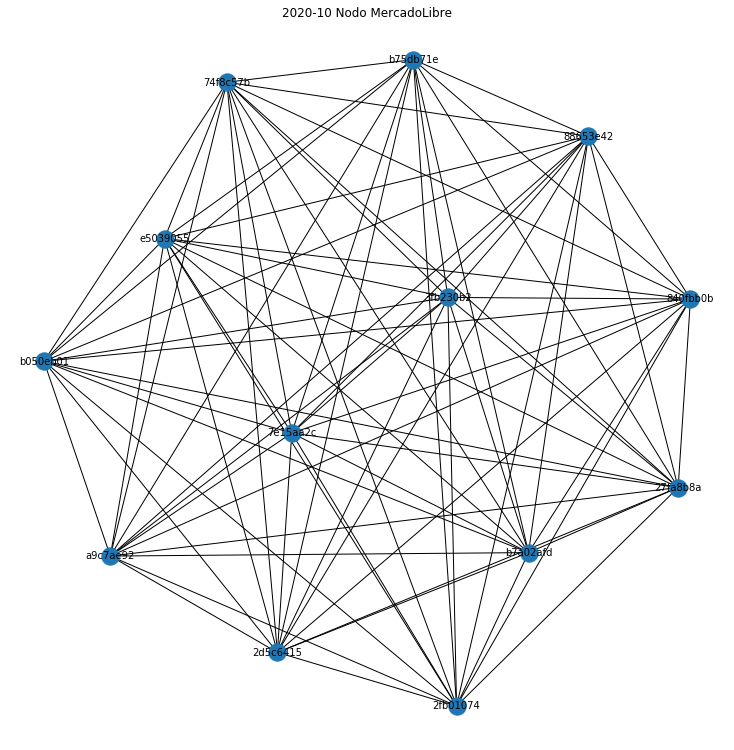

In [83]:
plt.figure(3,figsize=(10,10))
nx.draw_spring(G0_k_p_1_a,  with_labels = True, font_size = 10)
#plt.title('2020-10 Nodo MercadoLibre')
#plt.savefig('./images/G0_k_p_1_a_MercadoLibre.jpeg',bbox_inches = 'tight')

In [262]:
element_k_p_2_a = graphs_list_p_2_month[128][0]
Gcc_k_p_2_a = sorted(nx.connected_components(element_k_p_2_a), key=len, reverse=True)
G0_k_p_2_a = element_k_p_2_a.subgraph(Gcc_k_p_2_a[0])

In [263]:
val = pd.DataFrame(nx.degree(G0_k_p_2_a)).sort_values(1).iloc[-10:][0]
freq = pd.DataFrame(nx.degree(G0_k_p_2_a)).sort_values(1).iloc[-10:][1]

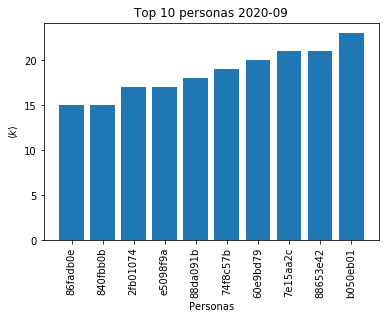

In [264]:
plt.bar(val,freq)
plt.xticks(rotation = 90, fontsize = 10)
plt.ylabel(r"$\langle k \rangle$")
plt.xlabel('Personas')
plt.title('Top 10 personas 2020-09')
plt.savefig('./images/Top_10_personas_k_mean_c_2_2020_09.jpeg',bbox_inches = 'tight')
plt.show()

In [100]:
colors = ['red' if node in val.values else 'lightblue' for node in G0_k_p_2_a.nodes()]

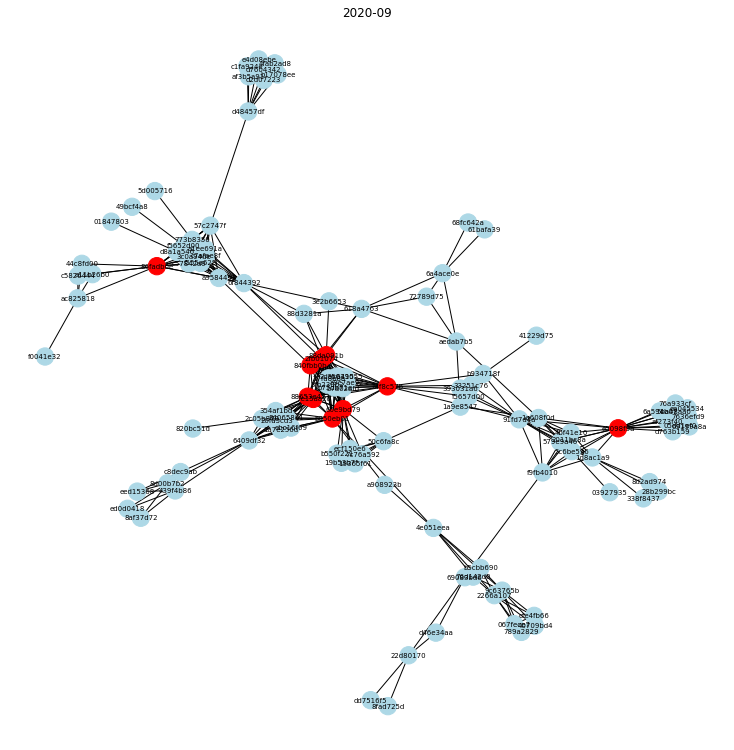

In [106]:
plt.figure(3,figsize=(10,10))
nx.draw_spring(G0_k_p_2_a, node_color=colors, with_labels = True, font_size = 7)
plt.title('2020-09')
plt.savefig('./images/G0_k_p_2_a.jpeg',bbox_inches = 'tight')

In [265]:
element_k_p_2_d = graphs_list_p_2_month[131][0]
Gcc_k_p_2_d = sorted(nx.connected_components(element_k_p_2_d), key=len, reverse=True)
G0_k_p_2_d = element_k_p_2_a.subgraph(Gcc_k_p_2_d[0])

In [266]:
val = pd.DataFrame(nx.degree(G0_k_p_2_d)).sort_values(1).iloc[-10:][0]
freq = pd.DataFrame(nx.degree(G0_k_p_2_d)).sort_values(1).iloc[-10:][1]

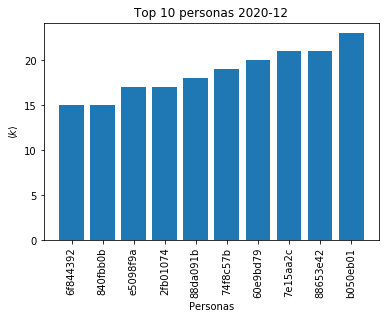

In [267]:
plt.bar(val,freq)
plt.xticks(rotation = 90, fontsize = 10)
plt.ylabel(r"$\langle k \rangle$")
plt.xlabel('Personas')
plt.title('Top 10 personas 2020-12')
plt.savefig('./images/Top_10_personas_k_mean_c_2_2020_12.jpeg',bbox_inches = 'tight')
plt.show()

In [112]:
colors = ['red' if node in val.values else 'lightblue' for node in G0_k_p_2_a.nodes()]

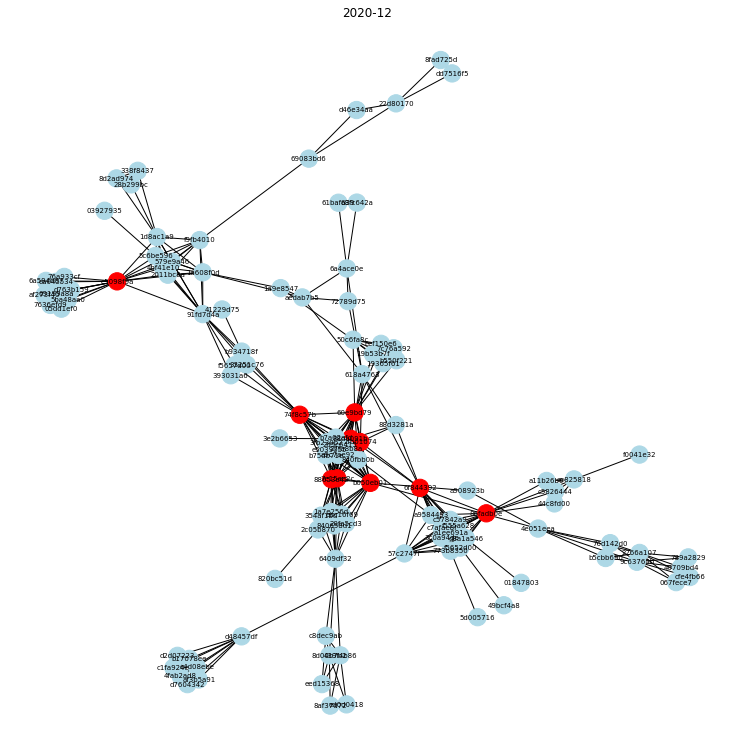

In [113]:
plt.figure(3,figsize=(10,10))
nx.draw_spring(G0_k_p_2_a, node_color=colors, with_labels = True, font_size = 7)
plt.title('2020-12')
plt.savefig('./images/G0_k_p_2_d.jpeg',bbox_inches = 'tight')

In [196]:
element_complete = graphs_list[20][0]
Gcc_complete = sorted(nx.connected_components(element_complete), key=len, reverse=True)
G0_complete = element_complete.subgraph(Gcc_complete[0])

In [ ]:
plt.figure(3,figsize=(10,10))
nx.draw_spring(element_complete,  with_labels = True, font_size = 7)
plt.title('2020-12')
#plt.savefig('./images/G0_k_p_2_d.jpeg',bbox_inches = 'tight')

In [ ]:
#Distribuciones de grado


In [164]:
vals_c_a = pd.DataFrame(nx.degree(graphs_list_c_2_month[128][0]))[1].value_counts().index
freq_c_a = pd.DataFrame(nx.degree(graphs_list_c_2_month[128][0]))[1].value_counts().values
vals_c_d = pd.DataFrame(nx.degree(graphs_list_c_2_month[131][0]))[1].value_counts().index
freq_c_d = pd.DataFrame(nx.degree(graphs_list_c_2_month[131][0]))[1].value_counts().values

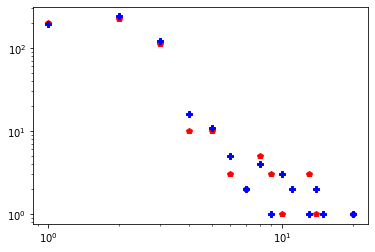

In [174]:
plt.loglog(vals_c_a,freq_c_a,'rp', label = '2020-09')
plt.loglog(vals_c_d,freq_c_d,'bP')
#plt.ylabel(r"$\langle k \rangle$")
#plt.xlabel('Personas')
#plt.title('Top 10 personas 2020-12')
plt.show()

In [ ]:
#Gigant component
def gigant_componente(list_, size):
    sizes = []
    for element, date in list_:
        Gcc = sorted(nx.connected_components(element), key=len, reverse=True)
        G0 = review.subgraph(Gcc[0])
        sizes.append(len(G0)/size)
    return sizes

In [ ]:
#Componente gigante
gc_people_month_1 = gigant_componente(graphs_list_p_month,386)
gc_people_month_2= gigant_componente(graphs_list_p_2_month,386)

In [ ]:
# Componente gigante empresas 
plt.figure(3,figsize=(20,20)) 
plt.plot(k_average_p_1_month, gc_people_month_1, label = 'Criterio 1')
#plt.plot(k_average_p_1_month, gc_people_month_2, label = 'Criterio 1')
plt.legend()
plt.plot()

In [ ]:
# Componente gigante empresas 
plt.figure(3,figsize=(20,20)) 
#plt.plot(k_average_p_1_month, gc_people_month_1, label = 'Criterio 2')
plt.plot(k_average_p_2_month, gc_people_month_2, label = 'Criterio 2')
plt.legend()
plt.plot()

In [115]:
#Toda la red fina
G0 = graphs_list[154][0]

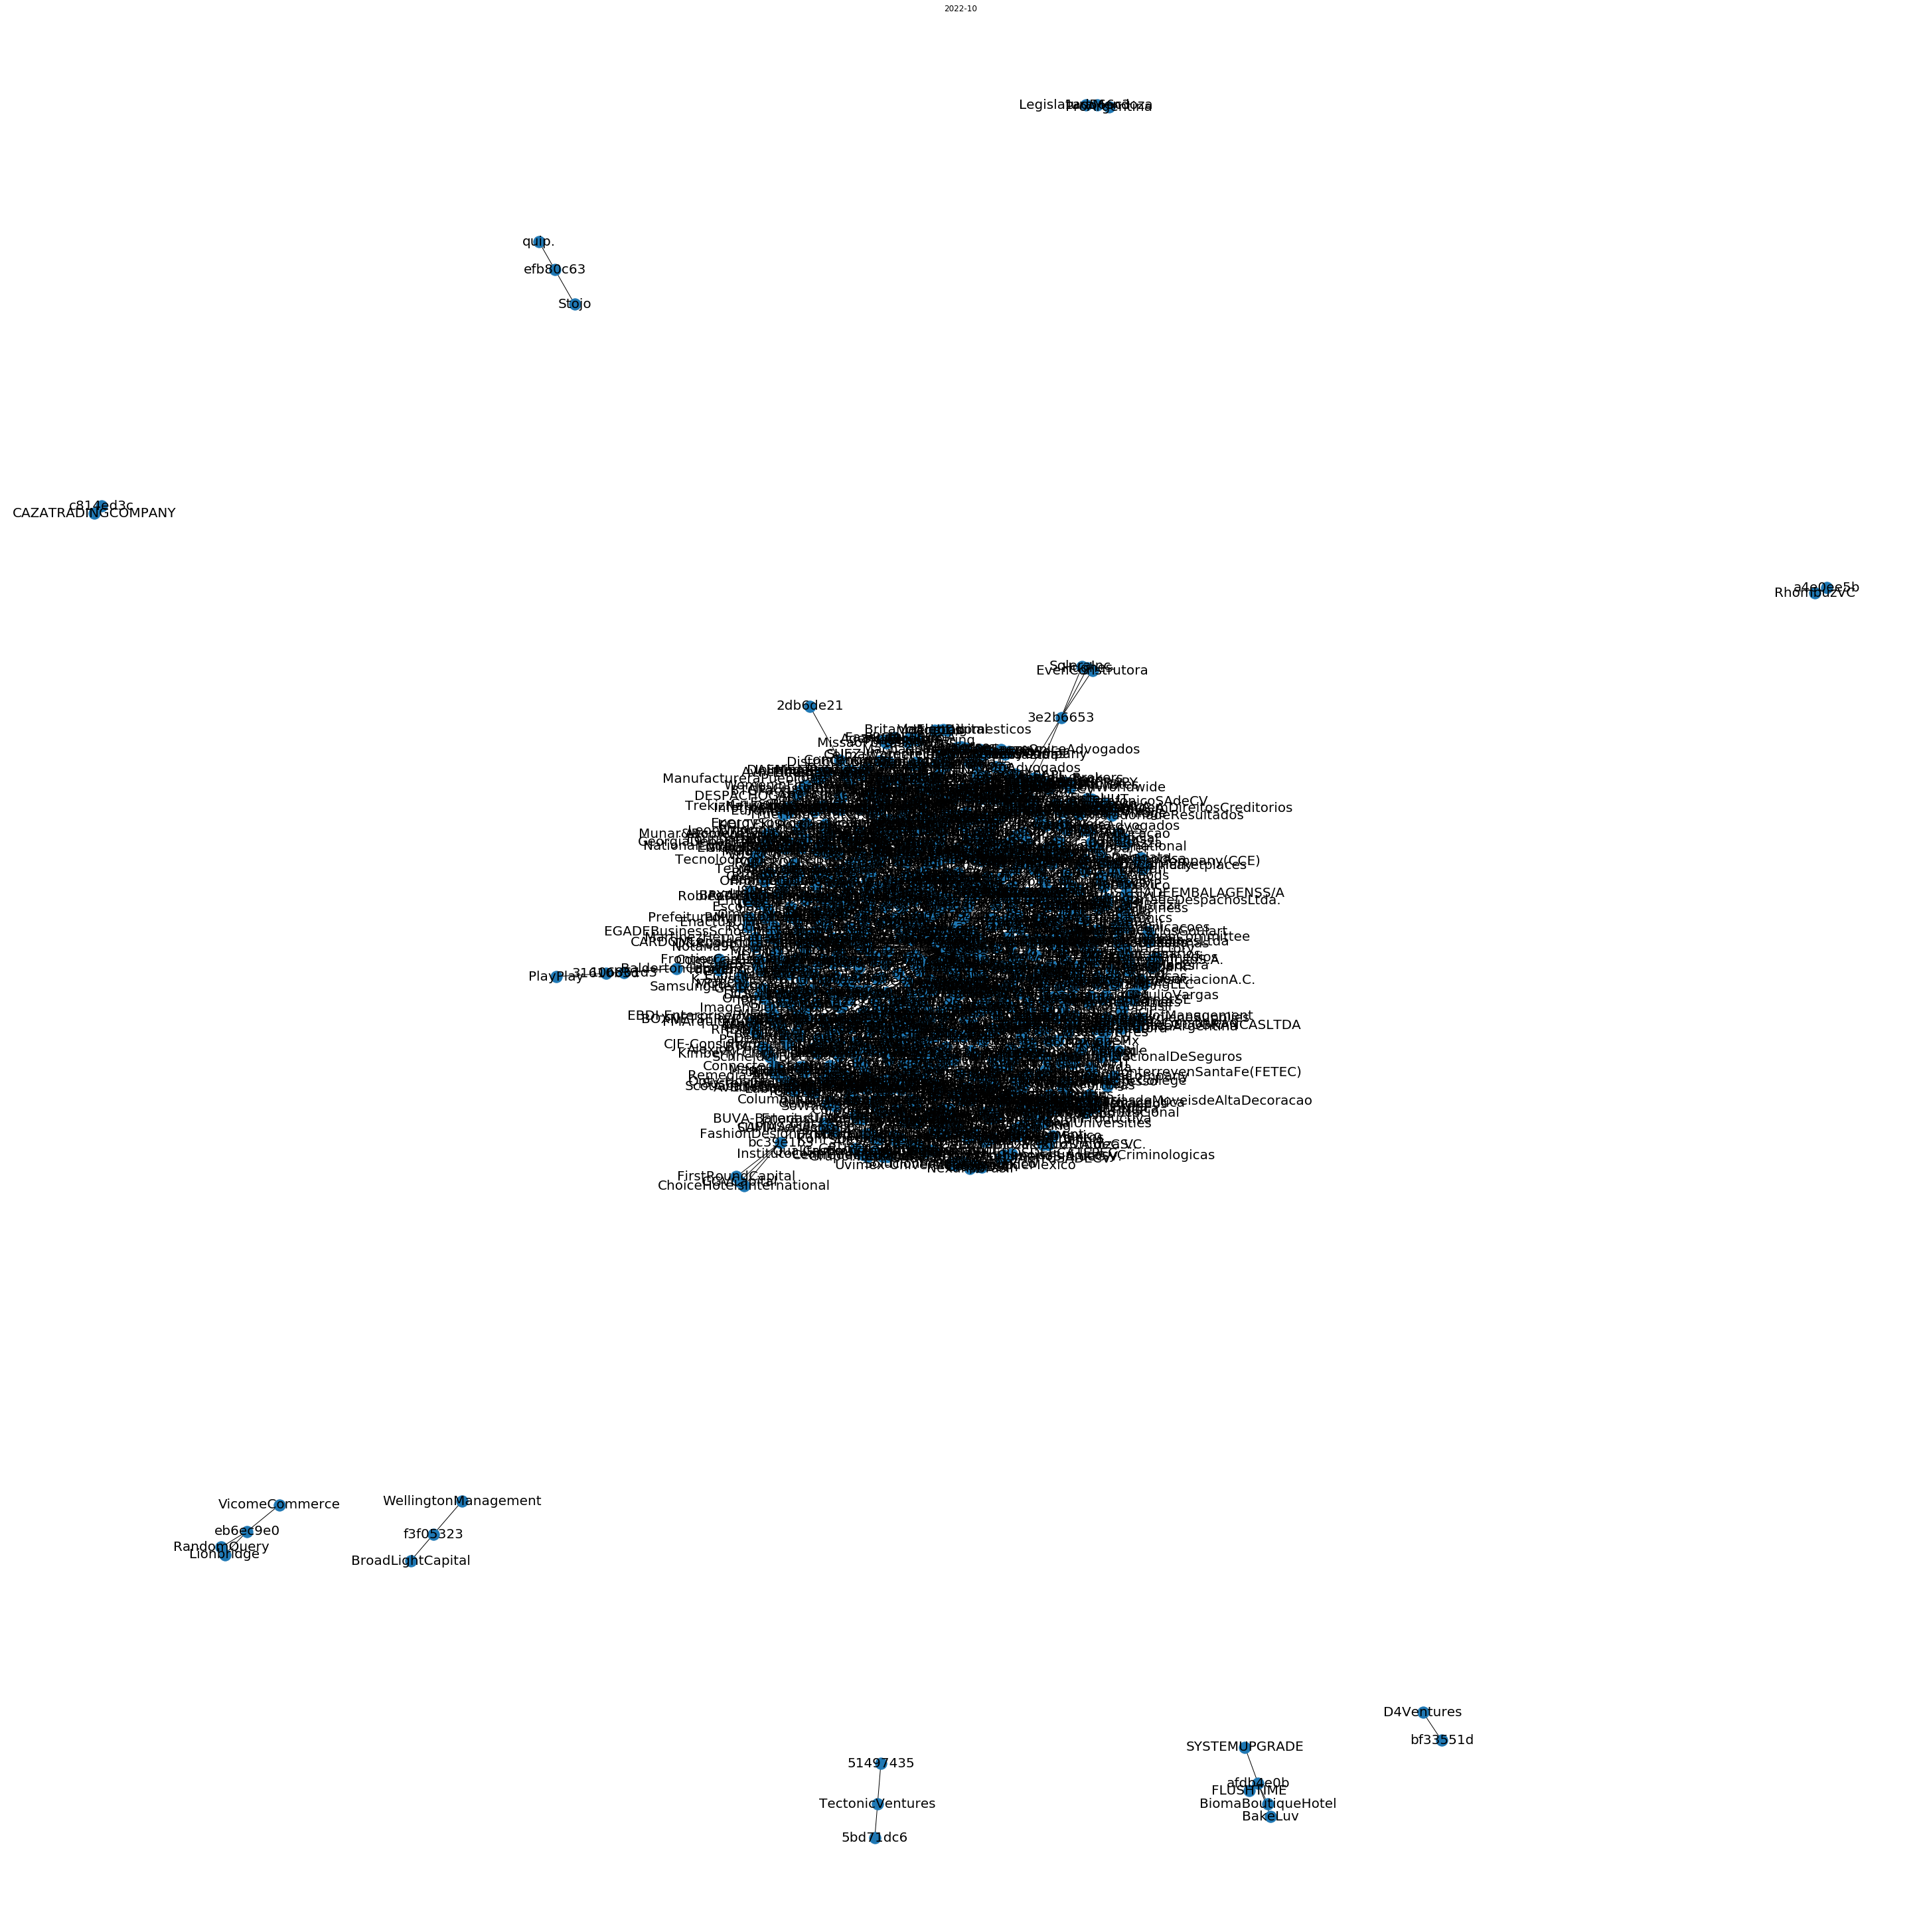

In [117]:
plt.figure(3,figsize=(40,40))
nx.draw_spring(G0, with_labels = True, font_size = 20)
plt.title('2022-10')
plt.savefig('./images/red final.jpeg',bbox_inches = 'tight')

In [126]:
DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.uuid == '5bd71dc6'].company.value_counts()

TectonicVentures         71
WayScript                52
Perch                    37
Merama                   24
HarvardBusinessSchool    18
Name: company, dtype: int64

# Verificacion de probabilidad

In [150]:
#KDE esperado
mn = dist_de_cambio.min()
mx =  dist_de_cambio.max()
kde_xs = np.linspace(mn, mx, 300)
kde_esperado = st.gaussian_kde(dist_de_cambio)
cdf_esperado = np.vectorize(lambda x: kde_esperado.integrate_box_1d(-np.inf, x))

In [175]:
rw_name = []
P_p = []
ks_statistic =[]
ks_pvalue = []
for random_walk_name in glob.glob('./Visits_Rw/Rw_Transition_2_gamma_976/*.dat'):
#Leemos resultados de la simulacion
    random_walk =  pd.read_csv(random_walk_name)
    random_walk_df = pd.DataFrame()
    changes = []
    for Rw in random_walk.Rw.unique():
        _aux = random_walk[random_walk.Rw == Rw].reset_index(drop = True)
        changes.append(0)
        for row in range(len(_aux.t)-1):
            if _aux.iloc[row + 1].N_visited != _aux.iloc[row].N_visited:
                changes.append(1)
            else:
                changes.append(0)
        random_walk_df = pd.concat([random_walk_df,_aux])[['Rw','N_visited','t']]

    random_walk_df['changes'] = changes
    P_de_cambio = pd.pivot_table(random_walk_df, index = 't', columns = 'changes', values = 'Rw', aggfunc = 'count').fillna(0)
    P_de_cambio['total'] = P_de_cambio[0] + P_de_cambio[1]
    dist_de_cambio_simulacion = P_de_cambio[1]/P_de_cambio['total']
    
    #
    mn_simulacion = dist_de_cambio_simulacion.min()
    mx_simulacion =  dist_de_cambio_simulacion.max()
    kde_xs_simulacion = np.linspace(mn_simulacion, mx, 300)
     
    #Calculamos KS
    kde_simulacion = st.gaussian_kde(dist_de_cambio_simulacion)
    cdf_simulacion = np.vectorize(lambda x: kde_simulacion.integrate_box_1d(-np.inf, x))
    
    ks = st.ks_2samp(cdf_simulacion(kde_xs_simulacion),cdf_esperado(kde_xs))
    
    #probabilidad promedio de cambiarse
    print(random_walk_name)
    print('Probabilidad promedio:',dist_de_cambio_simulacion.mean())
    print('K-S:',ks)
    print("*"*20)
    rw_name.append(random_walk_name)
    P_p.append(dist_de_cambio_simulacion.mean())
    ks_statistic.append(ks.statistic)
    ks_pvalue.append(ks.pvalue)

./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_0.dat
Probabilidad promedio: 0.02379766175102968
K-S: Ks_2sampResult(statistic=0.2833333333333333, pvalue=5.191390347437448e-11)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_0_.dat
Probabilidad promedio: 0.023681413577786685
K-S: Ks_2sampResult(statistic=0.2833333333333333, pvalue=5.191390347437448e-11)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_1.dat
Probabilidad promedio: 0.02306695894778801
K-S: Ks_2sampResult(statistic=0.2966666666666667, pvalue=4.783786471507949e-12)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_10.dat
Probabilidad promedio: 0.02505978477481073
K-S: Ks_2sampResult(statistic=0.2966666666666667, pvalue=4.783786471507949e-12)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_10_.dat
Probabilidad promedio: 0.023797661751029674
K-S: Ks_2sampResult(statistic=0.27333333

./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_27_.dat
Probabilidad promedio: 0.023482130995084415
K-S: Ks_2sampResult(statistic=0.32, pvalue=5.563730678470443e-14)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_28.dat
Probabilidad promedio: 0.02388069616048896
K-S: Ks_2sampResult(statistic=0.2733333333333333, pvalue=2.876765319621712e-10)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_28_.dat
Probabilidad promedio: 0.025557991231566417
K-S: Ks_2sampResult(statistic=0.31, pvalue=3.922502017067572e-13)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_29.dat
Probabilidad promedio: 0.02486050219210846
K-S: Ks_2sampResult(statistic=0.2966666666666667, pvalue=4.783786471507949e-12)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_29_.dat
Probabilidad promedio: 0.023050352065896153
K-S: Ks_2sampResult(statistic=0.27, pvalue=5.01791941596116e-10

./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_45_.dat
Probabilidad promedio: 0.02358177228643555
K-S: Ks_2sampResult(statistic=0.27, pvalue=5.01791941596116e-10)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_46.dat
Probabilidad promedio: 0.024063371861299376
K-S: Ks_2sampResult(statistic=0.2866666666666667, pvalue=2.8915775251270757e-11)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_46_.dat
Probabilidad promedio: 0.024096585625083086
K-S: Ks_2sampResult(statistic=0.26666666666666666, pvalue=8.690124079460009e-10)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_47.dat
Probabilidad promedio: 0.024478543908595773
K-S: Ks_2sampResult(statistic=0.2833333333333333, pvalue=5.191390347437448e-11)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_47_.dat
Probabilidad promedio: 0.024943536601567746
K-S: Ks_2sampResult(statistic=0.296666666666666

./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_63_.dat
Probabilidad promedio: 0.02339909658562513
K-S: Ks_2sampResult(statistic=0.2633333333333333, pvalue=1.4942294797261553e-09)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_64.dat
Probabilidad promedio: 0.024046764979407515
K-S: Ks_2sampResult(statistic=0.2733333333333333, pvalue=2.876765319621712e-10)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_64_.dat
Probabilidad promedio: 0.02394712368805638
K-S: Ks_2sampResult(statistic=0.26, pvalue=2.550959337009968e-09)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_65.dat
Probabilidad promedio: 0.02421283379832607
K-S: Ks_2sampResult(statistic=0.27, pvalue=5.01791941596116e-10)
********************
./Visits_Rw/Rw_Transition_2_gamma_976\Rw_0.976000_100.000000_65_.dat
Probabilidad promedio: 0.024445330144812056
K-S: Ks_2sampResult(statistic=0.2866666666666667, pvalue=2.89157

In [176]:
#pd.DataFrame({'Rw':rw_name, 'P media': P_p, 'ks_statistic':ks_statistic, 'ks_pvalue':ks_pvalue}).to_excel('Estadisticos_Transition_2_gamma_976.xlsx', index = False)

In [139]:
q25, q75 = np.percentile(dist_de_cambio_simulacion_2, [25, 75])
bin_width = 2 * (q75 - q25) * (len(dist_de_cambio_simulacion_2) ** (-1/3))
bins = round((dist_de_cambio_simulacion_2.max() - dist_de_cambio_simulacion_2.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

Freedman–Diaconis number of bins: 12


# Graficas de Probabilidad conjuntas

NameError: name 'kde_xs' is not defined

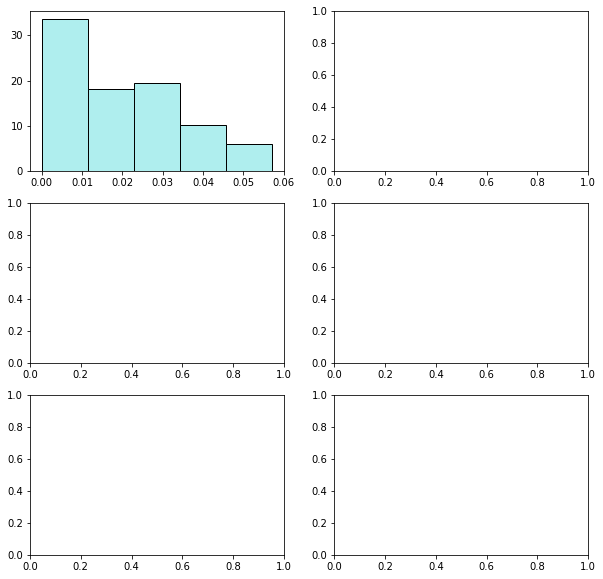

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(10,10))
line_labels = ["FPD",'CFPD', "Data","Simulation 1" ]


axes[0,0].hist(dist_de_cambio, density=1, bins=5, edgecolor = 'k', color = 'paleturquoise')
axes[0,0].plot(kde_xs, kde_esperado.pdf(kde_xs), color = 'orange', label = "DPF")
axes[0,0].set_title('(a)')
axes[0,0].set_ylabel('Probabilidad')

axes[0,1].hist(dist_de_cambio, density=1, bins=5, cumulative = True,  edgecolor = 'k',label = "Data",color = 'paleturquoise')
axes[0,1].plot(kde_xs, cdf_esperado(kde_xs), color = 'm', label = "CDF")
axes[0,1].set_title('(b)')
axes[0,1].set_ylabel('Probabilidad Acumulada')

axes[1,0].hist(dist_de_cambio_simulacion, density=1, bins=9, edgecolor = 'k', color = 'khaki', label = "Transicion 1")
axes[1,0].plot(kde_xs, kde_simulacion.pdf(kde_xs_simulacion),  color = 'orange')
axes[1,0].set_title('(c)')
axes[1,0].set_ylabel('Probabilidad')

axes[1,1].hist(dist_de_cambio_simulacion, density=1, bins=9,  cumulative = True,  edgecolor = 'k', color = 'khaki')
axes[1,1].plot(kde_xs, cdf_simulacion(kde_xs_simulacion),  color = 'm')
axes[1,1].set_title('(d)')
axes[1,1].set_ylabel('Probabilidad Acumulada')


axes[2,0].hist(dist_de_cambio_simulacion_2, density=1, bins=12, edgecolor = 'k', color = 'bisque', label = "Transicion 2")
axes[2,0].plot(kde_xs_simulacion_2[:250], kde_simulacion_2.pdf(kde_xs_simulacion_2[:250]),  color = 'orange')
axes[2,0].set_title('(e)')
axes[2,0].set_ylabel('Probabilidad')

axes[2,1].hist(dist_de_cambio_simulacion_2, density=1, bins=12,  cumulative = True,  edgecolor = 'k', color = 'bisque')
axes[2,1].plot(kde_xs_simulacion_2[:250], cdf_simulacion_2(kde_xs_simulacion_2[:250]),  color = 'm')
axes[2,1].set_title('(f)')
axes[2,1].set_ylabel('Probabilidad Acumulada')

lines = []
labels = []

for ax in  fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

    
fig.legend(lines, labels,           
           loc="upper right")    

plt.subplots_adjust(right=.85, top = 1)
ax.set_xlabel('% Cambio de empresa en un periodo', size = 10) 
ax.xaxis.set_label_coords(-.1,-.15)
#plt.ylabel("common Y")
#ax.yaxis.set_label_coords(-.1,-.15)


#plt.savefig('./images/Pruebas de probabilidades.jpeg',bbox_inches = 'tight')
plt.show()


In [ ]:
#KS

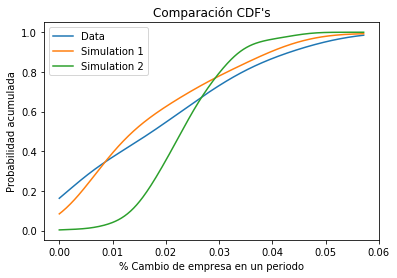

In [149]:
plt.plot(kde_xs, cdf_esperado(kde_xs), label = "Data")
plt.plot(kde_xs, cdf_simulacion(kde_xs),  label = 'Transicion 1')
plt.plot(kde_xs, cdf_simulacion_2(kde_xs), label = 'Transicion 2')

plt.title("Comparación CDF's")
plt.legend()

plt.xlabel('% Cambio de empresa en un periodo')
plt.ylabel('Probabilidad acumulada')

#plt.savefig('./images/Comparacion ks.jpeg',bbox_inches = 'tight')
plt.show()

for random_walk in glob.glob('./Visits_Rw/*.dat'):
    #Leemos resultados de la simulacion
    random_walk =  pd.read_csv(random_walk)
    Rws = []
    N_visiteds = []
    ts = []
    for Rw in random_walk.Rw.unique():random_walk_df['changes'] = changes
        _aux = random_walk[random_walk.Rw == Rw].reset_index()
        time = 0
        for row in range(len(_aux.t)-1):
            Rws.append(Rw)
            if _aux.iloc[row + 1].N_visited != _aux.iloc[row].N_visited:
                N_visiteds.append(_aux.iloc[row].N_visited)
                ts.append(time)
            else:
                N_visiteds.append(_aux.iloc[row].N_visited)
                ts.append(time) 
                time += 1
    random_walk_df = pd.DataFrame({'Rw':Rws,'N_visited':N_visiteds,'t':ts})
    P_period = random_walk_df.groupby(['Rw','t']).nunique()['N_visited'].reset_index()[['Rw','t','N_visited']]
    cambiaron = P_period[P_period.N_visited >= 2].groupby('t').nunique()['Rw']
    quedaron = P_period.groupby('t').nunique()['Rw']
    dist_periodo = cambiaron/quedaron
    #probabilidad promedio de cambiarse
    print(dist_periodo.mean())

# Homologacion de periodos y cambios de empresa

In [ ]:
#Creamos funcion que homologa periodos

In [197]:
for random_walk_name in glob.glob('./Visits_Rw/Rw_Transition_1_gamma_997_q_991\Rw_0.997000_0.991000_0.dat'):#glob.glob('./Visits_Rw/*.dat')
    random_walk =  pd.read_csv(random_walk_name)
    Rws = []
    N_visiteds = []
    ts = []
    for Rw in random_walk.Rw.unique():
        _aux = random_walk[random_walk.Rw == Rw].reset_index()
        time = 0
        for row in range(len(_aux.t)-1):
            Rws.append(Rw)
            if _aux.iloc[row + 1].N_visited != _aux.iloc[row].N_visited:
                N_visiteds.append(_aux.iloc[row].N_visited)
                ts.append(time)
            else:
                N_visiteds.append(_aux.iloc[row].N_visited)
                ts.append(time) 
                time += 1
    random_walk_df = pd.DataFrame({'Rw':Rws,'N_visited':N_visiteds,'t':ts})
    print(random_walk_name.replace('Visits_Rw','clean_visited_rw'))
    random_walk_df.to_csv(random_walk_name.replace('Visits_Rw','clean_visited_rw'))
"""    total_periods = random_walk_df.t.max()
    Rws = []
    N_visiteds = []
    ts = []
    for Rw in random_walk_df.Rw.unique():
        _aux = random_walk_df[random_walk_df.Rw == Rw].reset_index()
        for time in range(total_periods):
            Rws.append(Rw)
            if time > _aux.iloc[time].t:
                print(_aux.iloc[time])
                ts.append(time)
                N_visiteds.append(_aux.iloc[time-1].N_visited)
            else:
                ts.append(time)
                N_visiteds.append(_aux.iloc[time].N_visited)
    random_walk_df_ = pd.DataFrame({'Rw':Rws,'N_visited':N_visiteds,'t':ts})"""


./clean_visited_rw/Rw_Transition_1_gamma_997_q_991\Rw_0.997000_0.991000_0.dat


FileNotFoundError: [Errno 2] No such file or directory: './clean_visited_rw/Rw_Transition_1_gamma_997_q_991\\Rw_0.997000_0.991000_0.dat'

# Random Walk

In [4]:
#Leemos el grafo
graphs_list_Rw, companys, people, years, df = random_walk_list('./Visits_Rw/Rw_Transition_1_gamma_997_q_991\Rw_0.997000_0.991000_0.dat')

In [5]:
#Companys
graphs_list_c_month_Rw = bipartite_list(graphs_list_Rw, companys)

In [6]:
#People
graphs_list_p_month_Rw = bipartite_list(graphs_list_Rw, people)

In [7]:
#K average
k_average_c_1_month_Rw = k_average(graphs_list_c_month_Rw)
k_average_p_1_month_Rw = k_average(graphs_list_p_month_Rw)

In [188]:
#C average
C_average_c_1_month_Rw  = C_average(graphs_list_c_month_Rw)
C_average_p_1_month_Rw  = C_average(graphs_list_p_month_Rw)

In [189]:
#Segundo Criterio
graphs_list_Rw_2 = second_criteria(graphs_list_Rw)

In [190]:
#Companys
graphs_list_c_2_month_Rw = bipartite_list(graphs_list_Rw_2, companys)

In [191]:
#People
graphs_list_p_2_month_Rw = bipartite_list(graphs_list_Rw_2, people)

In [192]:
#K average
k_average_c_2_month_Rw = k_average(graphs_list_c_2_month_Rw)
k_average_p_2_month_Rw = k_average(graphs_list_p_2_month_Rw)
#C average
C_average_c_2_month_Rw  = C_average(graphs_list_c_2_month_Rw)
C_average_p_2_month_Rw  = C_average(graphs_list_p_2_month_Rw)

# Promedios Rw

In [19]:
#Homologamos todos los RWs en un solo DF
contador = 0
DF_Rws = pd.DataFrame()
for element in glob.glob('.\Visits_Rw\Rw_Transition_2_gamma_976\*.dat'):
    #print(element) 
    df = pd.read_csv(element)
    df['Iteration'] = contador
    contador += 1
    DF_Rws = pd.concat([DF_Rws,df])

In [20]:
DF_Rws.to_csv('.\Visits_Rw\Rw_Transition_2_gamma_976\All_iterations.txt', index = False)

In [21]:
DF_Rws.drop(['q','gamma'], axis = 1, inplace = True)

In [23]:
for iteration in DF_Rws.Iteration.unique():#Range 100
    print(iteration)
    element = DF_Rws[DF_Rws.Iteration == iteration]
    #Leemos el grafo
    graphs_list_Rw, companys, people, year, graph = random_walk_list(element)
    bipartite_people = bipartite_list(graphs_list_Rw, people)
    bipartite_company = bipartite_list(graphs_list_Rw, companys)
    
    #Calculamos K average
    k_people_1 = k_average(bipartite_people)
    k_companys_1 = k_average(bipartite_company)
    
    #Calculamos C Average
    C_people_1 = C_average(bipartite_people)
    C_companys_1 = C_average(bipartite_company)
    
    #Calculamos Segundo Criterio
    graphs_list_Rw_2 = second_criteria(graphs_list_Rw)
    bipartite_people_2 = bipartite_list(graphs_list_Rw_2, people)
    bipartite_company_2 = bipartite_list(graphs_list_Rw_2, companys)
    
    #Calculamos K average
    k_people_2 = k_average(bipartite_people_2)
    k_companys_2 = k_average(bipartite_company_2)
    
    #Calculamos C Average
    C_people_2 = C_average(bipartite_people_2)
    C_companys_2 = C_average(bipartite_company_2)
    
    DF = pd.DataFrame({'k_people_1':k_people_1,
                 'k_companys_1':k_companys_1,
                 'C_people_1':C_people_1,
                 'C_companys_1':C_companys_1,
                 'k_people_2':k_people_2,
                 'k_companys_2':k_companys_2,
                 'C_people_2':C_people_2,
                 'C_companys_2':C_companys_2})
    
    DF.to_csv('.\Data\k_and_C_average_Transition_2_gamma_976\Rw_0.976000_100.000000_' + str(iteration) + '.txt')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158


In [76]:
#Leemos los resultados para sacar los promedios 
Transition_1_df = pd.DataFrame()
for element in glob.glob('.\Data\k_and_C_average_Transition_1_gamma_997_q_991\*.txt'):
    _aux = pd.read_csv(element)
    Transition_1_df = pd.concat([Transition_1_df,_aux])
    
    
Transition_2_df = pd.DataFrame()
for element in glob.glob('.\Data\k_and_C_average_Transition_2_gamma_976\*.txt'):
    _aux = pd.read_csv(element)
    Transition_2_df = pd.concat([Transition_2_df,_aux])

In [96]:
replace_dict = {'[':'',']':''}

In [102]:
def replace(word, replace_dict):
    for key, value in replace_dict.items():
        word = word.replace(key, value)
    return word

In [107]:
Transition_1_df.k_people_1 = Transition_1_df.k_people_1.apply(lambda x: replace(x, replace_dict)).astype(float)
Transition_1_df.k_companys_1 = Transition_1_df.k_companys_1.apply(lambda x: replace(x, replace_dict)).astype(float)
Transition_1_df.k_people_2 = Transition_1_df.k_people_2.apply(lambda x: replace(x, replace_dict)).astype(float)
Transition_1_df.k_companys_2 = Transition_1_df.k_companys_2.apply(lambda x: replace(x, replace_dict)).astype(float)
Transition_2_df.k_people_1 = Transition_2_df.k_people_1.apply(lambda x: replace(x, replace_dict)).astype(float)
Transition_2_df.k_companys_1 = Transition_2_df.k_companys_1.apply(lambda x: replace(x, replace_dict)).astype(float)
Transition_2_df.k_people_2 = Transition_2_df.k_people_2.apply(lambda x: replace(x, replace_dict)).astype(float)
Transition_2_df.k_companys_2 = Transition_2_df.k_companys_2.apply(lambda x: replace(x, replace_dict)).astype(float)

In [108]:
Transition_1_df = Transition_1_df.groupby('Unnamed: 0').mean().iloc[:129]
Transition_2_df = Transition_2_df.groupby('Unnamed: 0').mean().iloc[:129]

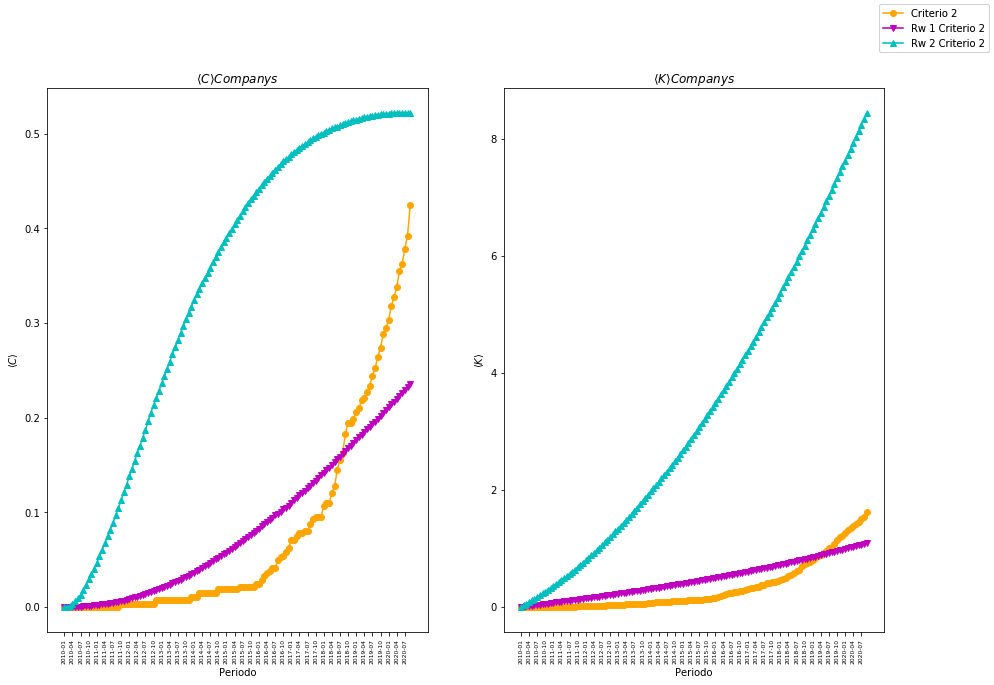

In [136]:
#People
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,10))
line_labels = ['Criterio 1','Criterio 2']

axes[0].plot(years, C_average_c_2_month[:129],color = 'orange', marker = 'o', label = 'Criterio 2')
#axes[0].plot(years, C_average_c_1_month[:129],color = 'blue', marker = 'o',  label = 'Criterio 1')
#axes[0].plot(years, Transition_1_df.C_companys_1, color = 'red', marker = "v", label = "Rw 1 Criterio 1" )
axes[0].plot(years, Transition_1_df.C_companys_2, color = 'm', marker = "v", label = "Rw 1 Criterio 2" )
#axes[0].plot(years, Transition_2_df.C_companys_1, color = 'y', marker = "^", label = "Rw 2 Criterio 1" )
axes[0].plot(years, Transition_2_df.C_companys_2 , color = "c",marker = "^", label = "Rw 2 Criterio 2")

axes[0].set_title(r'$\langle C \rangle  Companys$')
axes[0].set_ylabel(r'$\langle C \rangle$')
axes[0].set_xlabel('Periodo')
axes[0].set_xticks(years[::3])
axes[0].set_xticklabels(years[::3],rotation = 90, fontsize = 6)

axes[1].plot(years, k_average_c_2_month[:129],color = 'orange', marker = 'o')
#axes[1].plot(years, k_average_c_1_month[:129],color = 'blue', marker = 'o')
#axes[1].plot(years, Transition_1_df.k_companys_1, color = 'red', marker = "v")
axes[1].plot(years, Transition_1_df.k_companys_2, color = 'm', marker = "v")
#axes[1].plot(years, Transition_2_df.k_companys_1, color = 'y', marker = "^")
axes[1].plot(years, Transition_2_df.k_companys_2, color = "c",marker = "^")


axes[1].set_title(r'$\langle K \rangle  Companys$')
axes[1].set_ylabel(r'$\langle K \rangle$')
axes[1].set_xlabel('Periodo')
axes[1].set_xticks(years[::3])
axes[1].set_xticklabels(years[::3],rotation = 90, fontsize = 6)


lines = []
labels = []

for ax in  fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

    fig.legend(lines, labels,           
           loc="upper") 
plt.savefig('./images/Resultados_centralidad_companys.jpeg')
plt.show()

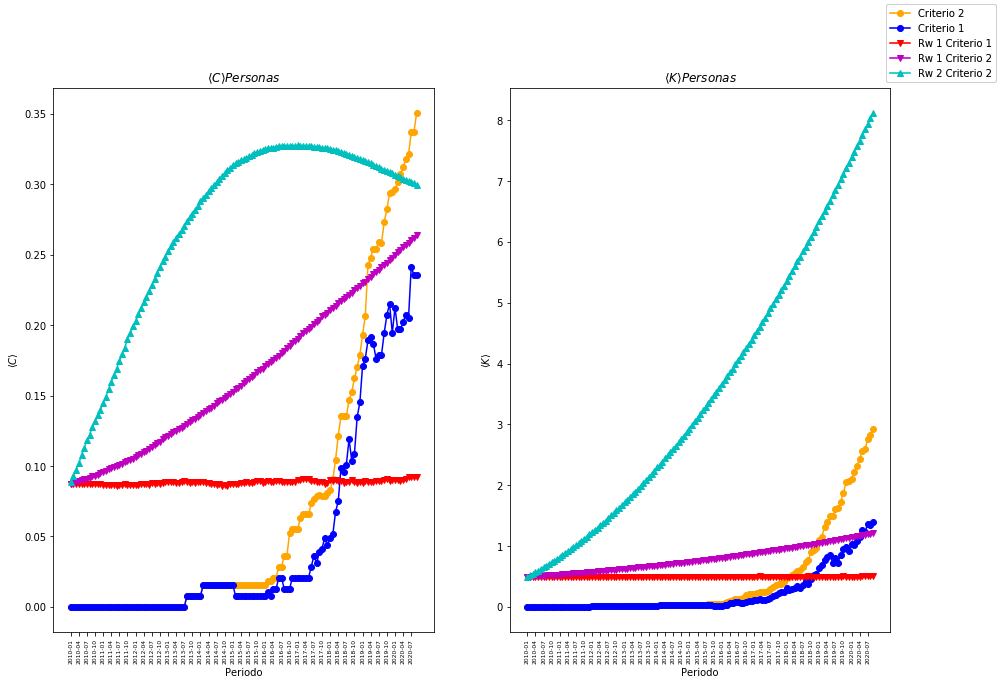

In [139]:
#Companys
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,10))
line_labels = ['Criterio 1','Criterio 2']

axes[0].plot(years, C_average_p_2_month[:129],color = 'orange', marker = 'o', label = 'Criterio 2')
axes[0].plot(years, C_average_p_1_month[:129],color = 'blue', marker = 'o',  label = 'Criterio 1')
axes[0].plot(years, Transition_1_df.C_people_1, color = 'red', marker = "v", label = "Rw 1 Criterio 1" )
axes[0].plot(years, Transition_1_df.C_people_2, color = 'm', marker = "v", label = "Rw 1 Criterio 2" )
#axes[0].plot(years, Transition_2_df.C_people_1, color = 'y', marker = "^", label = "Rw 2 Criterio 1" )
axes[0].plot(years, Transition_2_df.C_people_2 , color = "c",marker = "^", label = "Rw 2 Criterio 2")

axes[0].set_title(r'$\langle C \rangle  Personas$')
axes[0].set_ylabel(r'$\langle C \rangle$')
axes[0].set_xlabel('Periodo')
axes[0].set_xticks(years[::3])
axes[0].set_xticklabels(years[::3],rotation = 90, fontsize = 6)

axes[1].plot(years, k_average_p_2_month[:129],color = 'orange', marker = 'o')
axes[1].plot(years, k_average_p_1_month[:129],color = 'blue', marker = 'o')
axes[1].plot(years, Transition_1_df.k_people_1, color = 'red', marker = "v")
axes[1].plot(years, Transition_1_df.k_people_2, color = 'm', marker = "v")
#axes[1].plot(years, Transition_2_df.k_people_1, color = 'y', marker = "^")
axes[1].plot(years, Transition_2_df.k_people_2, color = "c",marker = "^")


axes[1].set_title(r'$\langle K \rangle  Personas$')
axes[1].set_ylabel(r'$\langle K \rangle$')
axes[1].set_xlabel('Periodo')
axes[1].set_xticks(years[::3])
axes[1].set_xticklabels(years[::3],rotation = 90, fontsize = 6)


lines = []
labels = []

for ax in  fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

    fig.legend(lines, labels,           
           loc="upper") 
plt.savefig('./images/Resultados_centralidad_personas.jpeg')
plt.show()

# Un solo Rw

In [158]:
#Analizamos un Rw
for iteration in [r'C:\Users\Lenovo\Desktop\Semestre 2023-01\Redes\Visits_Rw\Rw_Transition_1_gamma_997_q_991\Rw_0.997000_0.991000_51.dat']:#Range 100
    print(iteration)
    #element = DF_Rws[DF_Rws.Iteration == iteration]
    #Leemos el grafo
    graphs_list_Rw, companys, people, year, DF = random_walk_list(iteration)
    bipartite_people = bipartite_list(graphs_list_Rw, people)
    bipartite_company = bipartite_list(graphs_list_Rw, companys)
    
    #Calculamos K average
    k_people_1 = k_average(bipartite_people)
    k_companys_1 = k_average(bipartite_company)
    
    #Calculamos C Average
    C_people_1 = C_average(bipartite_people)
    C_companys_1 = C_average(bipartite_company)
    
    #Calculamos Segundo Criterio
    graphs_list_Rw_2 = second_criteria(graphs_list_Rw)
    bipartite_people_2 = bipartite_list(graphs_list_Rw_2, people)
    bipartite_company_2 = bipartite_list(graphs_list_Rw_2, companys)
    
    #Calculamos K average
    k_people_2 = k_average(bipartite_people_2)
    k_companys_2 = k_average(bipartite_company_2)
    
    #Calculamos C Average
    C_people_2 = C_average(bipartite_people_2)
    C_companys_2 = C_average(bipartite_company_2)

C:\Users\Lenovo\Desktop\Semestre 2023-01\Redes\Visits_Rw\Rw_Transition_1_gamma_997_q_991\Rw_0.997000_0.991000_51.dat


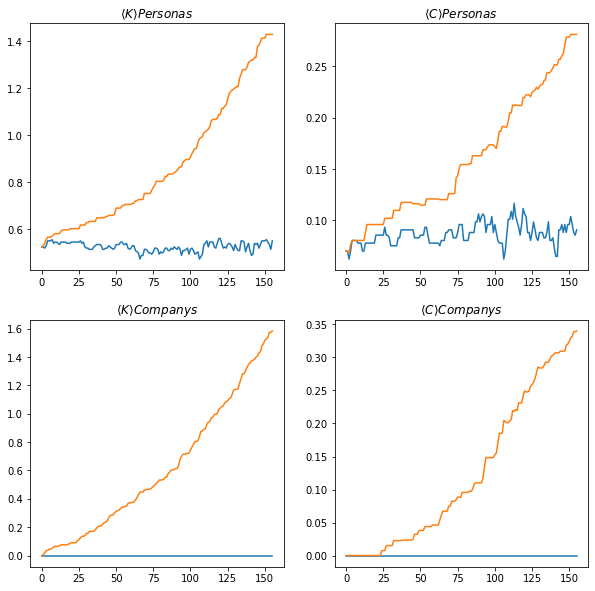

In [163]:
#Graficos
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(10,10))

axes[0,0].plot(year, k_people_1, label = 'K P Criterio 1')
axes[0,0].plot(year, k_people_2, label = 'K P Criterio 2')
axes[0,0].set_title(r'$\langle K \rangle  Personas$')

axes[0,1].plot(year, C_people_1, label = 'C P Criterio 1')
axes[0,1].plot(year, C_people_2, label = 'C P Criterio 2')
axes[0,1].set_title(r'$\langle C \rangle  Personas$')

axes[1,0].plot(year, k_companys_1, label = 'K C Criterio 1')
axes[1,0].plot(year, k_companys_2, label = 'K C Criterio 2')
axes[1,0].set_title(r'$\langle K \rangle  Companys$')

axes[1,1].plot(year, C_companys_1, label = 'C C Criterio 1')
axes[1,1].plot(year, C_companys_2, label = 'C C Criterio 2')
axes[1,1].set_title(r'$\langle C \rangle  Companys$')
plt.show()

In [148]:
#Cuantos de la red real empiezan en la misma empresa
DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.period == '2010-01'].sort_values('period').groupby('uuid').first().company.value_counts()

AdvocaciaCarlosGoulart                          1
HairImageBeautySalon                            1
EnelGreenPower                                  1
UniversidadNacionalAutonomadeMexico             1
ItauBBA                                         1
BDO                                             1
DELOITTE                                        1
RoblesTostadoCoronaySanchezGilS.C.              1
ORCOZOLASSESSORIAECONSULTORIADECOBRANCASLTDA    1
J.Macedo                                        1
BiomaBoutiqueHotel                              1
SaoPauloAirwaysComissariadeDespachosLtda.       1
XeroBoundaries                                  1
GE                                              1
CAZATRADINGCOMPANY                              1
A-Movil                                         1
McLanedoBrasil                                  1
CadenceEletrodomesticos                         1
CCEE                                            1
Name: company, dtype: int64

In [167]:
DF[DF.t == 0].groupby('Rw').first().N_visited.value_counts()

obscene        4
exhaust        4
nondescript    4
apology        3
cellar         3
              ..
diction        1
guerrilla      1
living         1
sleuth         1
corporation    1
Name: N_visited, Length: 299, dtype: int64